```
This software is a part of GPU Ocean.

Copyright (C) 2019  SINTEF Digital

This notebook evaluate simulation results against tide gauge 
measurements obtained from "Se havnivå" from Kartverket 

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [37]:
#Lets have matplotlib "inline"
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset

#Helpful during development
import importlib
#importlib.reload(module)

import datetime
import pandas as pd

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


from matplotlib import animation, rc
from matplotlib import pyplot as plt

from IPython.display import clear_output

#Set large figure sizes
plt.rcParams["animation.html"] = "jshtml" #Javascript 
#plt.rcParams["animation.html"] = "html5" #mp4
#plt.rcParams["figure.dpi"] = 300 #highres movies/plots (nice for web)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [2]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

from SWESimulators import FBL, CTCS, KP07, CDKLM16, PlotHelper, Common, WindStress, IPythonMagic, OceanographicUtilities

In [3]:
%cuda_context_handler gpu_ctx

# Select area and result folder

In [4]:


#case = 1 # Open waters in the Norwegian Sea
#case = 2 # Lofoten
case = 3 # The Norwegian Coast

casename = 'norwegian_sea_'


if case == 2:
    casename = 'lofoten_'
    
if case == 3:
    casename = 'complete_coast_'
    
folder = casename+datetime.datetime.now().strftime("%Y_%m_%d")

# Overrule the above folder name:
#folder = 'norwegian_sea_2019_10_09'
#folder = 'lofoten_2019_10_07'
#folder = 'complete_coast_2019_10_09' # havahol desktop
folder = 'complete_coast_2019_10_10' # havahol laptop


assert(folder.startswith(casename)), 'folder does not start with casename!'


os.makedirs(folder, exist_ok=True)
print(folder)

complete_coast_2019_10_10


# Misc helper functions

In [5]:
def printInfo(url):
    try:
        ncfile = Dataset(url)
        print("Variables")
        for var in ncfile.variables:
            print(var)

        print ("Attributes:")    
        for attr in ncfile.ncattrs():
            print(attr, ": ", ncfile.getncattr(attr))
    
    except Exception as e:
        raise e
        
    finally:
        ncfile.close()

In [6]:
def plotSolution(fig, 
                 eta, hu, hv, h, dx, dy, 
                 t, comment,
                 h_min=-1.5, h_max=1.5, 
                 uv_min=-0.05, uv_max=0.05, 
                 add_extra=False,
                 ax=None, sp=None):
    
    from datetime import timedelta
    fig.suptitle("Time = {:0>8} ({:s})".format(str(timedelta(seconds=int(t))), comment), 
                 fontsize=18,
                 horizontalalignment='left')
    
    ny, nx = eta.shape
    domain_extent = [0, nx*dx, 0, ny*dy]
    
    x_plots = 3
    y_plots = 1
    if (add_extra == True):
        x_plots=3
        y_plots=2
    
    V_max = 3 * (uv_max-uv_min) / np.max(h)
    R_min = -V_max/2000
    R_max = V_max/2000

    if (ax is None):
        ax = [None]*x_plots*y_plots
        sp = [None]*x_plots*y_plots
        
        ax[0] = plt.subplot(y_plots, x_plots, 1)
        sp[0] = ax[0].imshow(eta, interpolation="none", origin='bottom', 
                             cmap=plt.cm.coolwarm, 
                             vmin=h_min, vmax=h_max, 
                             extent=domain_extent)
        plt.colorbar(sp[0], shrink=0.9)
        plt.axis('image')
        plt.title("$\eta{}$")
        
        ax[1] = plt.subplot(y_plots, x_plots, 2)
        sp[1] = ax[1].imshow(hu, interpolation="none", origin='bottom', 
                             cmap=plt.cm.coolwarm, 
                             vmin=uv_min, vmax=uv_max, 
                             extent=domain_extent)
        plt.colorbar(sp[1], shrink=0.9)
        plt.axis('image')
        plt.title("$hu$")

        ax[2] = plt.subplot(y_plots, x_plots, 3)
        sp[2] = ax[2].imshow(hv, interpolation="none", origin='bottom', 
                             cmap=plt.cm.coolwarm, 
                             vmin=uv_min, vmax=uv_max, 
                             extent=domain_extent)
        plt.colorbar(sp[2], shrink=0.9)
        plt.axis('image')
        plt.title("$hv$")

        if (add_extra == True):
            V = PlotHelper.genVelocity(h, hu, hv)
            ax[3] = plt.subplot(y_plots, x_plots, 4)
            sp[3] = ax[3].imshow(V, interpolation="none", origin='bottom', 
                               cmap=plt.cm.Oranges, 
                               vmin=0, vmax=V_max, 
                               extent=domain_extent)
            plt.colorbar(sp[3], shrink=0.9)
            plt.axis('image')
            plt.title("Particle velocity magnitude")

            R = PlotHelper.genColors(h, hu/dy, hv/dx, plt.cm.seismic, R_min, R_max)
            ax[4] = plt.subplot(y_plots, x_plots, 5)
            sp[4] = ax[4].imshow(R, interpolation="none", 
                               origin='bottom', 
                               extent=domain_extent)
            plt.colorbar(sp[4], shrink=0.9)
            plt.axis('image')
            plt.title("Vorticity magnitude")
            
    else:        
        #Update plots
        fig.sca(ax[0])
        sp[0].set_data(eta)
        
        fig.sca(ax[1])
        sp[1].set_data(hu)
        
        fig.sca(ax[2])
        sp[2].set_data(hv)
        
        if (add_extra == True):
            V = PlotHelper.genVelocity(h, hu, hv)
            fig.sca(ax[3])
            sp[3].set_data(V)

            R = PlotHelper.genColors(h, hu/dx, hv/dy, plt.cm.seismic, R_min, R_max)
            fig.sca(ax[4])
            sp[4].set_data(R)
    
    return ax, sp

# Inspect URL and select area

In [7]:
nordic4km_url = 'http://thredds.met.no/thredds/dodsC/fou-hi/nordic4km-1h/Nordic-4km_SURF_1h_avg_00.nc'
norkyst800_url = 'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc'

local_norkyst800_url_havahol = '/media/havahol/Seagate Backup Plus Drive/gpu_ocean/cdklm_practicalities/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc'

source_url = norkyst800_url

if source_url == norkyst800_url and os.path.exists(local_norkyst800_url_havahol):
    source_url = local_norkyst800_url_havahol

In [156]:
try:
    ncfile = Dataset(source_url)
    H_full = np.array(ncfile.variables['h'])
    angle = np.array(ncfile.variables['angle'])
    print(H_full.shape)
    lat = np.array(ncfile.variables["lat"])
    lon = np.array(ncfile.variables["lon"])
    landmask = ncfile.variables['zeta'][0,:,:].mask
except Exception as e:
    raise e

finally:
    ncfile.close()
    
    

(902, 2602)
<class 'numpy.ndarray'>


<class 'numpy.ndarray'> True False


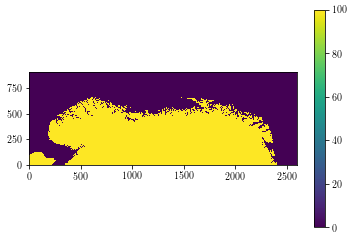

In [160]:
print(type(landmask), landmask.max(), landmask.min())
plt.imshow(landmask*100, origin='lower')
plt.colorbar()

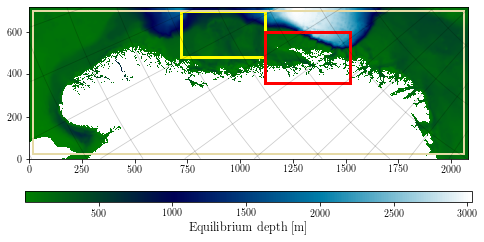

In [126]:
##### 
case2_x0 = 1400
case2_x1 = int(case2_x0 + 500)
case2_y0 = 450
case2_y1 = int(case2_y0 + 300)

#x0 = 1650
#x1 = int(x0 + 100)
#y0 = 450
#y1 = int(y0 + 200)

case1_x0 = 900
case1_x1 = 1400
case1_y0 = 600
case1_y1 = 875


case3_x0 = 25
case3_x1 = 2575
case3_y0 = 25
case3_y1 = 875


def plot_map(show_cases=True, star=None):
    land_value = H_full.min()
    (full_ny, full_nx) = H_full.shape

    # Makes sure axis are in km (assuming equidistant 800x800m grid)
    extent=np.array([0, full_nx*0.8, 0, full_ny*0.8])


    fig = plt.figure(figsize=(8,4))

    # Land and bathymetry
    land = np.ma.masked_where(H_full == land_value, H_full)
    im = plt.imshow(land, interpolation="None", origin='lower', cmap='ocean',
               extent=extent)

    cbar = fig.colorbar(im, orientation='horizontal', aspect=40)
    cbar.set_label('Equilibrium depth [m]', size=12.5)
    
    if star is not None:
        plt.scatter(star[1]*0.8, star[0]*0.8, s=100, c='r', marker='*')


    if show_cases:
        # Case boxes
        fig.gca().fill(np.array([case1_x0, case1_x0, case1_x1, case1_x1])*0.8, 
                       np.array([case1_y0, case1_y1, case1_y1, case1_y0])*0.8, 
                       fill=False, linestyle='-', linewidth=3, color='yellow')
        fig.gca().fill(np.array([case2_x0, case2_x0, case2_x1, case2_x1])*0.8, 
                       np.array([case2_y0, case2_y1, case2_y1, case2_y0])*0.8, 
                       fill=False, linestyle='-', linewidth=3, color='red')

        fig.gca().fill(np.array([case3_x0, case3_x0, case3_x1, case3_x1])*0.8, 
                       np.array([case3_y0, case3_y1, case3_y1, case3_y0])*0.8, 
                       fill=False, linestyle='-', linewidth=2, color='xkcd:beige')

    # Lat-lon lines
    plt.contour(lon, levels = np.arange(0, 40, 4), extent=extent, colors='k', alpha=0.2, linewidths=0.8)
    plt.contour(lat, levels = np.arange(56,77, 2), extent=extent, colors='k', alpha=0.2, linewidths=0.8)

plot_map()



In [10]:
## Select case

x0 = case1_x0
x1 = case1_x1
y0 = case1_y0
y1 = case1_y1

if case == 2:
    x0 = case2_x0
    x1 = case2_x1
    y0 = case2_y0
    y1 = case2_y1
    print('using the Lofoten case')

elif case == 3:
    x0 = case3_x0
    x1 = case3_x1
    y0 = case3_y0
    y1 = case3_y1
    print('using the complete coast case')

else:

    print('using Norwegian Sea area')


using the complete coast case


# Read a reference water level file


argmin:  1403998
site_y, site_x:  (539, 1520)
distances.shape (902, 2602)


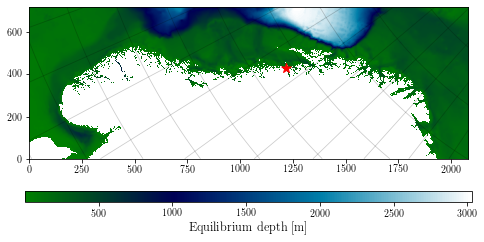

In [228]:
#reference_file = os.path.join('reference_data/bodo_msl.txt')
reference_file = os.path.join('reference_data', 'bodo_nn2000.txt')

def read_reference_file(filename):
    headers = ['datetime', 'observed', 'predicted']
    
    df = pd.read_csv(filename, delim_whitespace=True, skiprows=14, header=None, names=headers) # header=headers)
    df['datetime'] = pd.to_datetime(df['datetime'])
    
    return df


def get_meta_data(filename):
    sitename = None
    lat = None
    lon = None
    with open(filename) as file:
        for line in file:
            line = str(line)
    
            # Find simulator
            #match = re.match('#Site name':, line)
            if line.startswith('#Site name:'):
                sitename = line.replace('#Site name:', '').strip()
                if sitename.startswith('BOD'):
                    sitename = 'BODØ'
                elif sitename.startswith('HONNING'):
                    sitename = 'HONNINGSVÅG'
            elif line.startswith('#Latitude:'):
                lat = np.float(line.replace('#Latitude:','').strip())
            elif line.startswith('#Longitude:'):
                lon = np.float(line.replace('#Longitude:','').strip())
    return sitename, lat, lon


def get_cell_location(lat, lon, site_lat, site_lon, landmask):
    ny, nx = lat.shape
    search_nx = np.floor(nx/2)
    search_ny = np.floor(ny/2)
    
    distances = (lat-site_lat)**2 + (lon-site_lon)**2 + landmask*1000
    site_y, site_x = np.unravel_index(distances.argmin(), distances.shape)
    print('argmin: ', np.argmin(distances))
    print('site_y, site_x: ', (site_y, site_x))
    print('distances.shape', distances.shape)
    
    #fig = plt.figure(figsize=(7,7))
    #plt.imshow(distances, origin='lower')
    #plt.colorbar()
    
    return (site_y, site_x)
    
    
df = read_reference_file(reference_file)
sitename, site_lat, site_lon = get_meta_data(reference_file)
site_loc = get_cell_location(lat, lon, site_lat, site_lon, landmask)
plot_map(show_cases=False, star=site_loc)
#plot_df(df)
#pf

(y, x):  (514, 1495)
[ 0.40100002  0.03234677 -0.07861242 -0.30633545 -0.73560572 -1.25978768
 -1.50477791 -1.27426267 -0.5740726   0.27928299  0.85103226  0.90617549
  0.57097387  0.12310859 -0.23775327 -0.48514009 -0.70721245 -0.9772051
 -1.21127331 -1.17677569 -0.6997211   0.09670583  0.84131694  1.16254044]
len(t):  24
eta.shape: (24, 850, 2550)
complete_coast_2019_10_10\complete_coast_original.nc
eta.shape:  (24, 902, 2602)
len(t):  24
eta.shape: (24, 902, 2602)
[0.4010000228881836 0.11000000685453415 0.013000000268220901
 -0.16200000047683716 -0.6380000114440918 -1.277000069618225
 -1.5790001153945923 -1.2170000076293945 -0.30300000309944153
 0.6450000405311584 1.0890001058578491 0.8890000581741333
 0.4010000228881836 0.04000000283122063 -0.07600000500679016
 -0.15300001204013824 -0.46400001645088196 -1.037000060081482
 -1.4550000429153442 -1.2760000228881836 -0.4750000238418579
 0.5480000376701355 1.222000002861023 1.2330000400543213]


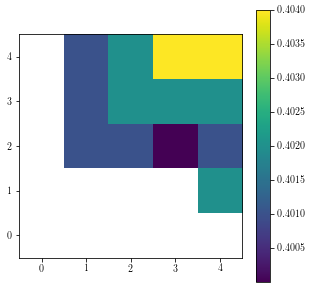

In [229]:
def get_simulated_sea_level_values(casename, site_loc):
    sim_result_file = os.path.join(folder, casename)
    
    try:
        ncfile = Dataset(sim_result_file)
        t = ncfile.variables['time'][:]

        eta = ncfile.variables['eta'][:,:,:]
    except Exception as e:
        raise e
    finally:
        ncfile.close()
        
        
    x = site_loc[1] - x0
    y = site_loc[0] - y0
    
    print('(y, x): ', (y, x))
    simulated_sea_level = eta[:, y, x]
    print(simulated_sea_level)
    
    print('len(t): ', len(t))
    print('eta.shape:',eta.shape)
        
    print(sim_result_file)
    return simulated_sea_level

def get_norkyst_sea_level_values(source_url, site_loc):
    
    try:
        ncfile = Dataset(source_url)
        t = ncfile.variables['time'][:]

        eta = ncfile.variables['zeta'][:,:,:]
    except Exception as e:
        raise e
    finally:
        ncfile.close()
        
        
    print('eta.shape: ', eta.shape)
    reference_sea_level = eta[:, site_loc[0], site_loc[1]]
    #print(simulated_sea_level)
    
    print('len(t): ', len(t))
    print('eta.shape:',eta.shape)
    
    
    fig = plt.figure(figsize=(5,5))
    plt.imshow(eta[0, site_loc[0]-2:site_loc[0]+3, site_loc[1]-2:site_loc[1]+3], 
               origin='lower', interpolation='none')
    plt.colorbar()
    
        
    print(reference_sea_level)
    return reference_sea_level
    
simulated_sea_level_original = get_simulated_sea_level_values(casename + 'original.nc', site_loc)
reference_sea_level_norkyst = get_norkyst_sea_level_values(source_url, site_loc)

144
2019-07-16 01:00:00+02:00


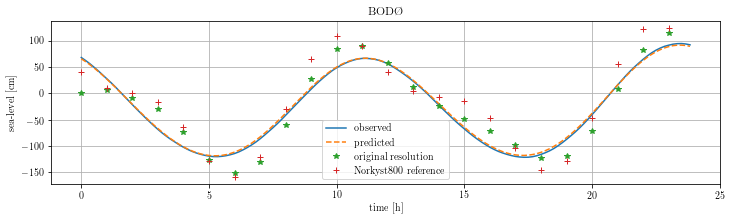

In [230]:
    
def plot_df(df, sitename=None, simulated_values=None, norkyst_values=None, ref_name=None):
    num_vals_in_a_day = 6*24
    start_index = 6
    end_index = num_vals_in_a_day + start_index
    print(num_vals_in_a_day)
    
    fig = plt.figure(figsize=(12,3))
    
    # Get time into decimal hours since the start of simulation
    print(df.iloc[0]['datetime'])
    time = pd.to_numeric(df.iloc[start_index:end_index]['datetime'] - df.iloc[start_index][0])/1e9/3600
    
    plt.plot(time, df.iloc[start_index:end_index]['observed'], label='observed')
    plt.plot(time, df.iloc[start_index:end_index]['predicted'], '--', label='predicted')
    if simulated_values is not None:
        plt.plot(simulated_values, '*', label='original resolution')
    if norkyst_values is not None:
        plt.plot(norkyst_values, '+', label='Norkyst800 reference')
    plt.legend()
    plt.xlabel('time [h]')
    plt.ylabel('sea-level [cm]')
    plt.grid()
    if sitename is not None:
        plt.title(sitename)
    #print(time[0].hour)
    if ref_name is not None:
        plt.savefig(ref_name.replace('.txt', '.pdf'))
        plt.savefig(ref_name.replace('.txt', '.png'))
                    

plot_df(df, sitename, 
        simulated_values=simulated_sea_level*100,
        norkyst_values=reference_sea_level_norkyst*100)

### Plot local area around star

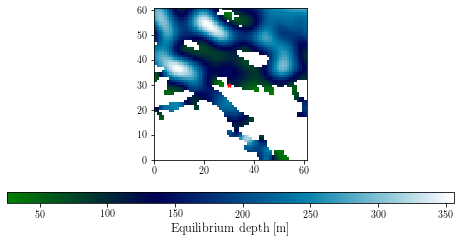

In [231]:
def plot_local_map(star):
    
    H_local = H_full[star[0]-30:star[0]+31, 
                     star[1]-30:star[1]+31]
    
    land_value = H_full.min()
    (full_ny, full_nx) = H_local.shape

    # Makes sure axis are in km (assuming equidistant 800x800m grid)
    extent=np.array([0, full_nx, 0, full_ny])


    fig = plt.figure(figsize=(8,4))

    # Land and bathymetry
    land = np.ma.masked_where(H_local == land_value, H_local)
    im = plt.imshow(land, interpolation="None", origin='lower', cmap='ocean',
               extent=extent)

    cbar = fig.colorbar(im, orientation='horizontal', aspect=40)
    cbar.set_label('Equilibrium depth [m]', size=12.5)
    
    plt.scatter(30, 30, s=20, c='red', marker='*')
plot_local_map(site_loc)

# Make reference plots for all interesting locations

In [232]:
def make_validation_plot(reference_file):
    
    # Read reference 
    df = read_reference_file(reference_file)
    sitename, site_lat, site_lon = get_meta_data(reference_file)
    
    site_loc = get_cell_location(lat, lon, site_lat, site_lon, landmask)
    plot_map(show_cases=False, star=site_loc)
    
    simulated_sea_level_original = get_simulated_sea_level_values(casename + 'original.nc', site_loc)
    reference_sea_level_norkyst = get_norkyst_sea_level_values(source_url, site_loc)
    
    plot_local_map(site_loc)
    
    plot_df(df, sitename, 
            simulated_values=simulated_sea_level_original*100,
            norkyst_values=reference_sea_level_norkyst*100,
            ref_name=reference_file)
    
    
    

argmin:  1403998
site_y, site_x:  (539, 1520)
distances.shape (902, 2602)
(y, x):  (514, 1495)
[ 0.40100002  0.03234677 -0.07861242 -0.30633545 -0.73560572 -1.25978768
 -1.50477791 -1.27426267 -0.5740726   0.27928299  0.85103226  0.90617549
  0.57097387  0.12310859 -0.23775327 -0.48514009 -0.70721245 -0.9772051
 -1.21127331 -1.17677569 -0.6997211   0.09670583  0.84131694  1.16254044]
len(t):  24
eta.shape: (24, 850, 2550)
complete_coast_2019_10_10\complete_coast_original.nc
eta.shape:  (24, 902, 2602)
len(t):  24
eta.shape: (24, 902, 2602)
[0.4010000228881836 0.11000000685453415 0.013000000268220901
 -0.16200000047683716 -0.6380000114440918 -1.277000069618225
 -1.5790001153945923 -1.2170000076293945 -0.30300000309944153
 0.6450000405311584 1.0890001058578491 0.8890000581741333
 0.4010000228881836 0.04000000283122063 -0.07600000500679016
 -0.15300001204013824 -0.46400001645088196 -1.037000060081482
 -1.4550000429153442 -1.2760000228881836 -0.4750000238418579
 0.5480000376701355 1.222000

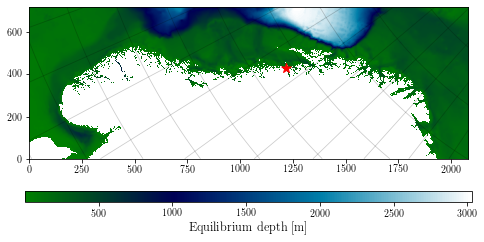

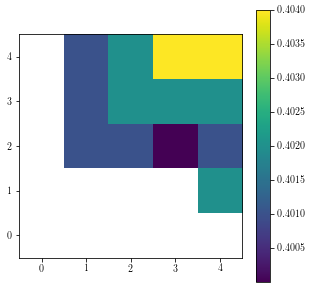

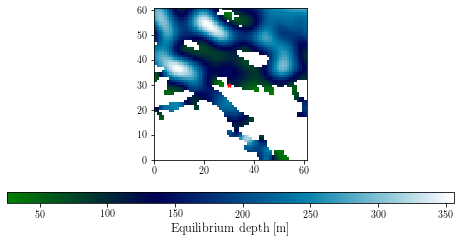

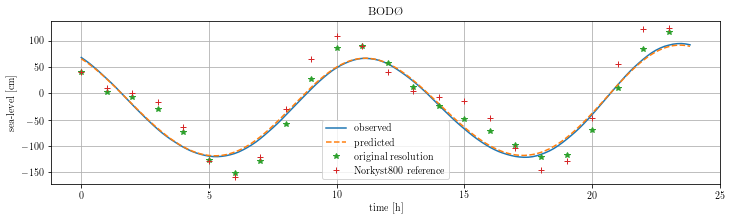

In [233]:
make_validation_plot(os.path.join('reference_data','bodo_nn2000.txt'))

argmin:  1418518
site_y, site_x:  (545, 428)
distances.shape (902, 2602)
(y, x):  (520, 403)
[-0.105      -0.35652816 -0.64520884 -0.71595067 -0.61655653 -0.4742651
 -0.29595855 -0.06890687  0.15606375  0.31042328  0.33743328  0.20676666
 -0.04487167 -0.33389848 -0.56397134 -0.66909254 -0.65015423 -0.53570771
 -0.35730231 -0.13094327  0.11133458  0.31013528  0.39262021  0.30862755]
len(t):  24
eta.shape: (24, 850, 2550)
complete_coast_2019_10_10\complete_coast_original.nc
eta.shape:  (24, 902, 2602)
len(t):  24
eta.shape: (24, 902, 2602)
[-0.10500000417232513 -0.3800000250339508 -0.5470000505447388
 -0.5860000252723694 -0.5260000228881836 -0.3920000195503235
 -0.19500000774860382 0.04500000178813934 0.2939999997615814
 0.45000001788139343 0.44300001859664917 0.28600001335144043
 0.00800000037997961 -0.28600001335144043 -0.484000027179718
 -0.5560000538825989 -0.5180000066757202 -0.398000031709671
 -0.2150000035762787 0.01600000075995922 0.2720000147819519
 0.47600001096725464 0.5279999

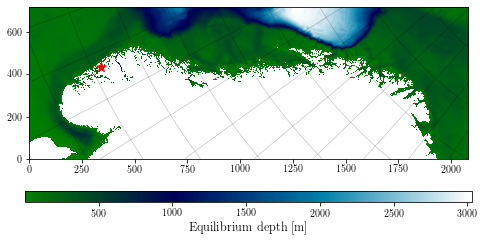

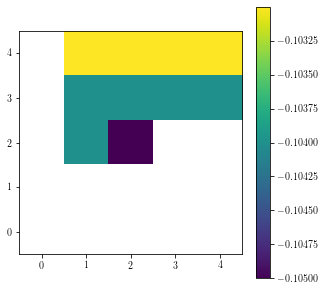

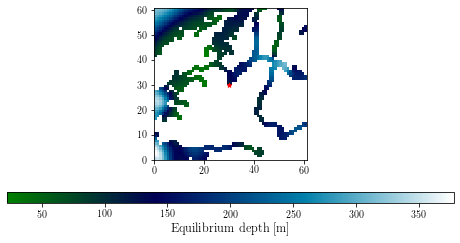

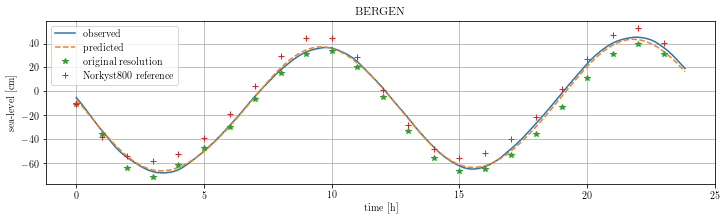

In [234]:
make_validation_plot(os.path.join('reference_data','bergen_nn2000.txt'))

argmin:  471506
site_y, site_x:  (181, 544)
distances.shape (902, 2602)
(y, x):  (156, 519)
[ 0.12        0.11763243  0.29580641  0.24089462  0.02854367 -0.125614
 -0.17371008 -0.24826026 -0.32426029 -0.3596271  -0.46585572 -0.48283041
 -0.37385324 -0.13146424  0.12238182  0.22540227  0.15332183 -0.03135496
 -0.19708127 -0.25121242 -0.233651   -0.25634441 -0.3520183  -0.44153878]
len(t):  24
eta.shape: (24, 850, 2550)
complete_coast_2019_10_10\complete_coast_original.nc
eta.shape:  (24, 902, 2602)
len(t):  24
eta.shape: (24, 902, 2602)
[0.12000000476837158 0.2880000174045563 0.31200000643730164
 0.22500000894069672 0.12300000339746475 0.07200000435113907
 0.018000001087784767 -0.0560000017285347 -0.16300000250339508
 -0.26500001549720764 -0.3240000009536743 -0.25200000405311584
 -0.026000000536441803 0.20800000429153442 0.28700000047683716
 0.20900000631809235 0.10200000554323196 0.06100000441074371
 0.05900000408291817 0.024000000208616257 -0.08800000697374344
 -0.22100001573562622 -0

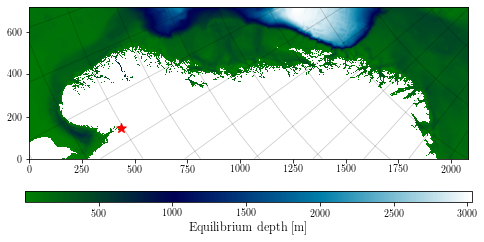

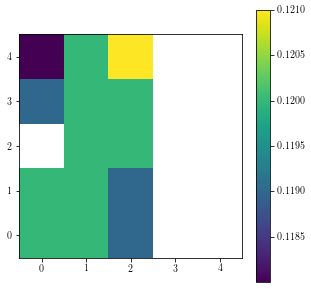

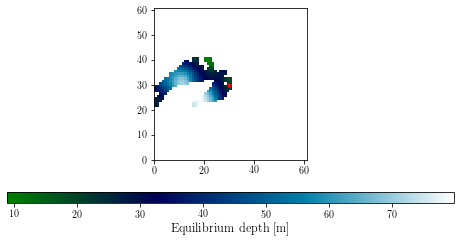

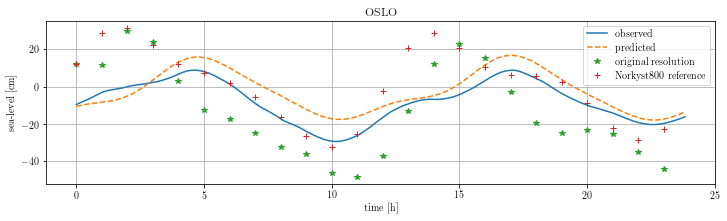

In [235]:
make_validation_plot(os.path.join('reference_data','oslo_nn2000.txt'))

argmin:  1128920
site_y, site_x:  (433, 2254)
distances.shape (902, 2602)
(y, x):  (408, 2229)
[ 0.30400002  0.60980964  0.84128559  0.85768574  0.54822451 -0.14235729
 -0.95109892 -1.45150304 -1.5273664  -1.20628643 -0.77150118 -0.3858318
 -0.03041947  0.30564594  0.64642453  0.83604747  0.66077477  0.11976984
 -0.62470084 -1.25179672 -1.45222902 -1.22614884 -0.77848601 -0.32082203]
len(t):  24
eta.shape: (24, 850, 2550)
complete_coast_2019_10_10\complete_coast_original.nc
eta.shape:  (24, 902, 2602)
len(t):  24
eta.shape: (24, 902, 2602)
[0.30400002002716064 0.6830000281333923 1.0070000886917114
 1.0160000324249268 0.5770000219345093 -0.15800000727176666
 -0.9140000343322754 -1.4100000858306885 -1.4930000305175781
 -1.1970000267028809 -0.7400000095367432 -0.3330000042915344
 0.00800000037997961 0.38100001215934753 0.7710000276565552
 0.9490000605583191 0.7070000171661377 0.0860000029206276
 -0.6480000019073486 -1.2110000848770142 -1.409000039100647
 -1.2040001153945923 -0.76500004529

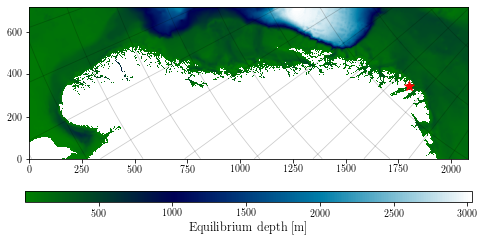

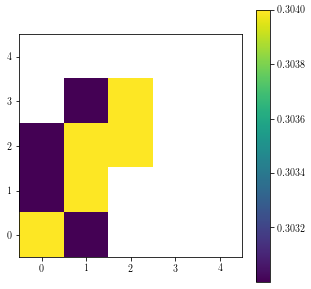

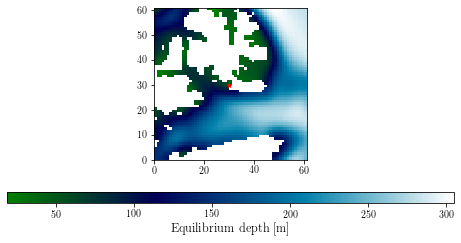

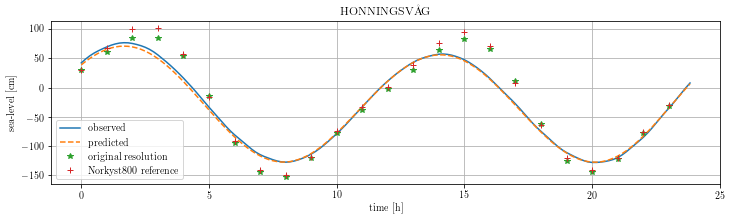

In [236]:
make_validation_plot(os.path.join('reference_data','honningsvaag_nn2000.txt'))

argmin:  655904
site_y, site_x:  (252, 200)
distances.shape (902, 2602)
(y, x):  (227, 175)
[ 0.059      -0.01121484  0.03390567  0.03387922  0.00914689 -0.08341309
 -0.15085395 -0.23131685 -0.28903472 -0.3042413  -0.2790443  -0.23306011
 -0.17838374 -0.1299029  -0.09076989 -0.07101862 -0.07023522 -0.09751578
 -0.15445977 -0.2221089  -0.27723375 -0.2984122  -0.2803762  -0.23367344]
len(t):  24
eta.shape: (24, 850, 2550)
complete_coast_2019_10_10\complete_coast_original.nc
eta.shape:  (24, 902, 2602)
len(t):  24
eta.shape: (24, 902, 2602)
[0.05900000408291817 0.10500000417232513 0.13300000131130219
 0.13100001215934753 0.11000000685453415 0.055000003427267075
 -0.01600000075995922 -0.09200000762939453 -0.14100000262260437
 -0.14900000393390656 -0.11300000548362732 -0.06100000441074371
 -0.0010000000474974513 0.055000003427267075 0.0950000062584877
 0.10900000482797623 0.09700000286102295 0.0560000017285347
 -0.003000000026077032 -0.07000000029802322 -0.12200000882148743
 -0.141000002622

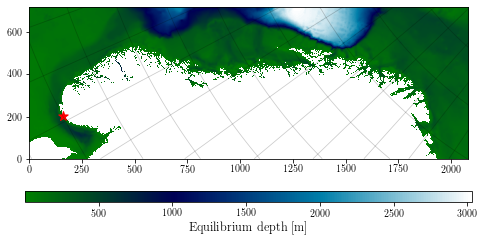

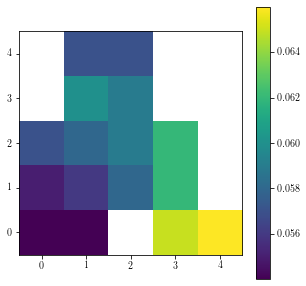

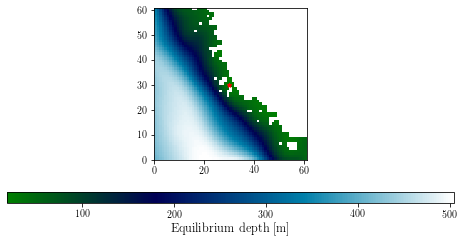

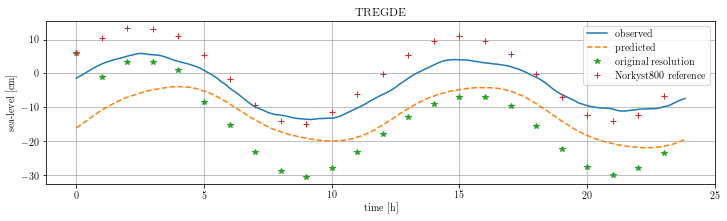

In [237]:
make_validation_plot(os.path.join('reference_data','tregde_nn2000.txt'))

argmin:  1307937
site_y, site_x:  (502, 1733)
distances.shape (902, 2602)
(y, x):  (477, 1708)
[ 0.21100001 -0.1420867  -0.0437826  -0.02220721 -0.24205557 -0.95706296
 -1.83819878 -2.13904071 -1.39472258 -0.0779127   1.11364722  1.66907859
  1.2961123   0.29260859 -0.57889187 -0.76602173 -0.56015766 -0.5813176
 -1.05933976 -1.62472713 -1.58056903 -0.62656587  0.71889091  1.72675121]
len(t):  24
eta.shape: (24, 850, 2550)
complete_coast_2019_10_10\complete_coast_original.nc
eta.shape:  (24, 902, 2602)
len(t):  24
eta.shape: (24, 902, 2602)
[0.2110000103712082 -0.17100000381469727 0.0990000069141388
 0.20000000298023224 -0.30800002813339233 -1.2790000438690186
 -2.0850000381469727 -1.8670001029968262 -0.5530000329017639
 0.9310000538825989 1.652000069618225 1.2780001163482666
 0.3570000231266022 -0.27400001883506775 -0.14400000870227814
 0.13700000941753387 -0.1080000028014183 -0.9000000357627869
 -1.8020000457763672 -1.9490001201629639 -0.9010000228881836
 0.6760000586509705 1.73700010

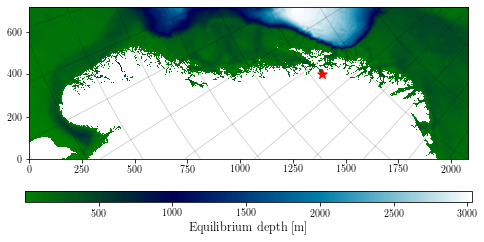

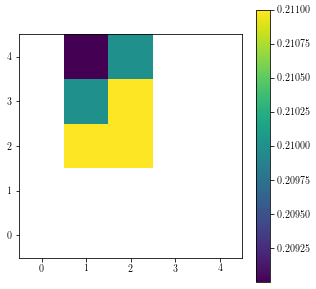

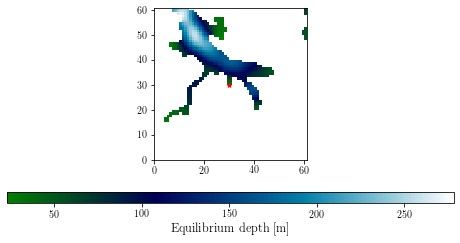

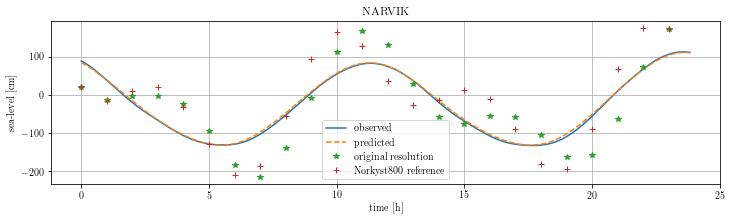

In [238]:
make_validation_plot(os.path.join('reference_data','narvik_nn2000.txt'))